In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import random
from transformers import BertTokenizer, BertModel
import json
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [38]:
device = "cpu"

In [2]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

#### BiLSTM CRF model

In [36]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, batch_size=1, device='cpu'):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.target_size = target_size
        self.batch_size = batch_size
        self.device = device
        self.tag_to_ix = tag_to_ix
        self.start_tag = start_tag
        self.end_tag = end_tag

        self.embedding = nn.Embedding.from_pretrained(embedding_mat).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)

        self.transitions_to = nn.Parameter(torch.randn(target_size, target_size)).to(device)
        self.transitions_to.data[start_tag, :] = -10000
        self.transitions_to.data[:, end_tag] = -10000

        # self.transitions_from = nn.Parameter(torch.randn(target_size, target_size))
        # self.transitions_from.data[:, start_tag] = -10000
        # self.transitions_from.data[end_tag, :] = -10000

        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(self.device),
                torch.randn(2, 1, self.hidden_dim // 2).to(self.device))

    def get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.embedding(sentence).view(len(sentence), 1, -1)
        #convert embeds to torch float32
        embeds = embeds.float()
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats


    def _forward_algo(self, lstm_features):

        scores = torch.full((1, self.target_size), -10000.).to(self.device)
        scores[0][self.start_tag] = 0.

        forward_var = scores

        for feat in lstm_features:
            next_tag_var = self.transitions_to + feat.view(-1, 1).expand(-1, self.target_size) + forward_var.expand(self.target_size, -1)
            max_score = next_tag_var.max(dim=1).values.view(-1, 1)
            next_tag_var = next_tag_var - max_score
            forward_var = (max_score + torch.logsumexp(next_tag_var, dim=1).view(-1, 1)).view(1, -1)
            
        terminal_var = (forward_var + self.transitions_to[self.end_tag]).view(1, -1)
        alpha = terminal_var
        max_score = alpha.max()
        alpha = max_score + torch.logsumexp(alpha - max_score, dim=1)
        return alpha
    

    def _score_sentence(self, lstm_features, tags):
        score = torch.zeros(1).to(self.device)
        tags = torch.cat([torch.tensor([self.tag_to_ix['START_TAG']], dtype=torch.long).to(self.device), tags])
        for i, feat in enumerate(lstm_features):
            score += self.transitions_to[tags[i + 1], tags[i]] + feat[tags[i + 1]]
                
        score += self.transitions_to[self.tag_to_ix['END_TAG'], tags[-1]]
        return score
    
    def neg_log_likelihood(self, sentence, tags):
        lstm_feats = self.get_lstm_features(sentence)
        forward_score = self._forward_algo(lstm_feats)
        gold_score = self._score_sentence(lstm_feats, tags)
        return forward_score - gold_score
    

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.target_size), -10000.).to(self.device)
        init_vvars[0][self.start_tag] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = [] 
            viterbivars_t = [] 

            next_tag_var = self.transitions_to + forward_var.expand(self.target_size, -1)
            best_tag_id = torch.argmax(next_tag_var, dim=1)
            bptrs_t = best_tag_id
            viterbivars_t = next_tag_var[range(len(best_tag_id)), best_tag_id].view(1, -1)
            
            forward_var = (viterbivars_t + feat).view(1, -1)
            backpointers.append(bptrs_t)

        
        terminal_var = forward_var + self.transitions_to[self.end_tag]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

       
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id.item())
        
        start = best_path.pop()
        best_path.reverse()
        return path_score, best_path
        
    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self.get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

        

In [5]:
train_data = json.load(open('../Dataset/NER_train.json', 'r'))
test_data = json.load(open('../Dataset/NER_test.json', 'r'))
val_data = json.load(open('../Dataset/NER_val.json', 'r'))

In [6]:
word_to_idx = {}

for case in train_data:
    for text in train_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in test_data:
    for text in test_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in val_data:
    for text in val_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

In [7]:
tag_to_ix = {}

for case in train_data:
    for tag in train_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in test_data:
    for tag in test_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in val_data:
    for tag in val_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

tag_to_ix['START_TAG'] = len(tag_to_ix)
tag_to_ix['END_TAG'] = len(tag_to_ix)

#### Bert Embeddings

In [8]:
# tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
# bert_model = BertModel.from_pretrained('nlpaueb/legal-bert-base-uncased')

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
# embedding_mat = np.zeros((len(word_to_idx), 768))

# for word, idx in tqdm(word_to_idx.items()):
#     # if word in tokenizer.vocab:
#     #     embedding_mat[idx] = bert_model(tokenizer.encode(word))[1].detach().numpy()
#     # else:
#     #     embedding_mat[idx] = np.random.rand(768)
#     try:
#         tokens = tokenizer.batch_encode_plus([word], return_tensors='pt', add_special_tokens=False)
#     except:
#         tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#         continue
#     embeddings = None
#     with torch.no_grad():
#         # outputs = bert_model(**tokens)
#         # embeddings = outputs.last_hidden_state
#         try:
#             outputs = bert_model(**tokens)
#             embeddings = outputs.last_hidden_state
#         except:
#             tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#             outputs = bert_model(**tokens)
#             embeddings = outputs.last_hidden_state
#     embeddings = embeddings.squeeze(0)
#     word_embeddings = embeddings.mean(dim = 0)
#     embedding_mat[idx] = word_embeddings.squeeze(0).numpy()

  0%|          | 0/39724 [00:00<?, ?it/s]

100%|██████████| 39724/39724 [21:43<00:00, 30.48it/s]


In [10]:
# pickle.dump(embedding_mat, open('legal_bert_embedding_mat.pkl', 'wb'))

In [8]:
embedding_mat = pickle.load(open('legal_bert_embedding_mat.pkl', 'rb'))

In [39]:
model = BiLSTM_CRF(len(word_to_idx), 768, 256, len(tag_to_ix), torch.tensor(embedding_mat), tag_to_ix['START_TAG'], tag_to_ix['END_TAG'], tag_to_ix, device=device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

EPOCHS = 10
train_loss = []
val_loss = []
train_macro_f1 = []
val_macro_f1 = []

for epoch in tqdm(range(EPOCHS), desc='Epoch'):
    loss = 0
    f1 = 0
    for i, case in tqdm(enumerate(train_data), desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        sentence = prepare_sequence(train_data[case]['text'].split(' '), word_to_idx)
        tags = prepare_sequence(train_data[case]['labels'], tag_to_ix)
        sentence = sentence.to(device)
        tags = tags.to(device)
        model.zero_grad()
        loss = model.neg_log_likelihood(sentence, tags)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        with torch.no_grad():
            preds = model(sentence)[1]
            tags = tags.cpu().numpy()
            f1 += f1_score(tags, preds, average='macro')
    
    train_loss.append(loss/len(train_data))
    train_macro_f1.append(f1/len(train_data))
    
    with torch.no_grad():
        loss = 0
        f1 = 0
        for case in val_data:
            sentence = prepare_sequence(val_data[case]['text'].split(' '), word_to_idx)
            tags = prepare_sequence(val_data[case]['labels'], tag_to_ix)
            setence = sentence.to(device)
            tags = tags.to(device)
            loss = model.neg_log_likelihood(sentence, tags)
            loss += loss.item()
            preds = model(sentence)[1]
            f1 += f1_score(tags.cpu().numpy(), preds, average='macro')
        val_macro_f1.append(f1/len(val_data))
        val_loss.append(loss/len(val_data))

    print()
    print(f'Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}')
    print(f'Train macro f1: {train_macro_f1[-1]}, Val macro f1: {val_macro_f1[-1]}')
    print(f'Epoch {epoch + 1}/{EPOCHS} done')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Dell\AppData\Local\Temp\ipykernel_16936\3491935838.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'Loss: {loss/i+1}, F1: {f1/i+1}')


Epoch 1/10, Case 0/8019 done
Loss: tensor([inf], grad_fn=<AddBackward0>), F1: inf


Epoch 1/10, Case 200/8019 done
Loss: tensor([1.2351], grad_fn=<AddBackward0>), F1: 1.451328664739248


Epoch 1/10, Case 400/8019 done
Loss: tensor([1.0316], grad_fn=<AddBackward0>), F1: 1.4478401084784005


Epoch 1/10, Case 600/8019 done
Loss: tensor([1.0859], grad_fn=<AddBackward0>), F1: 1.4377337963880261


Epoch 1/10, Case 800/8019 done
Loss: tensor([1.0074], grad_fn=<AddBackward0>), F1: 1.4480794281222813


Epoch 1/10, Case 1000/8019 done
Loss: tensor([1.0278], grad_fn=<AddBackward0>), F1: 1.4574211635279102


Epoch 1/10, Case 1200/8019 done
Loss: tensor([1.0005], grad_fn=<AddBackward0>), F1: 1.4572745492852865


Epoch 1/10, Case 1400/8019 done
Loss: tensor([1.0218], grad_fn=<AddBackward0>), F1: 1.45807158580529


Epoch 1/10, Case 1600/8019 done
Loss: tensor([1.0531], grad_fn=<AddBackward0>), F1: 1.4596942861002824


Epoch 1/10, Case 1800/8019 done
Loss: tensor([1.0235], grad_fn=<AddBackward0>), F1: 1.459251046664682


Epoch 1/10, Case 2000/8019 done
Loss: tensor([1.0187], grad_fn=<AddBackward0>), F1: 1.4593972174768086


Epoch 1/10, Case 2200/8019 done
Loss: tensor([1.0349], grad_fn=<AddBackward0>), F1: 1.4641183578692032


Epoch 1/10, Case 2400/8019 done
Loss: tensor([1.0324], grad_fn=<AddBackward0>), F1: 1.4693228091090313


Epoch 1/10, Case 2600/8019 done
Loss: tensor([1.0149], grad_fn=<AddBackward0>), F1: 1.4728979420700736


Epoch 1/10, Case 2800/8019 done
Loss: tensor([1.0080], grad_fn=<AddBackward0>), F1: 1.4769449989614598


Epoch 1/10, Case 3000/8019 done
Loss: tensor([1.0120], grad_fn=<AddBackward0>), F1: 1.4824133678760183


Epoch 1/10, Case 3200/8019 done
Loss: tensor([1.0003], grad_fn=<AddBackward0>), F1: 1.4869771624044008


Epoch 1/10, Case 3400/8019 done
Loss: tensor([1.0004], grad_fn=<AddBackward0>), F1: 1.4916480647591603


Epoch 1/10, Case 3600/8019 done
Loss: tensor([1.0055], grad_fn=<AddBackward0>), F1: 1.4964538299669032


Epoch 1/10, Case 3800/8019 done
Loss: tensor([1.0151], grad_fn=<AddBackward0>), F1: 1.5011049976078672


Epoch 1/10, Case 4000/8019 done
Loss: tensor([1.0120], grad_fn=<AddBackward0>), F1: 1.50374989639089


Epoch 1/10, Case 4200/8019 done
Loss: tensor([1.0025], grad_fn=<AddBackward0>), F1: 1.5065387033625663


Epoch 1/10, Case 4400/8019 done
Loss: tensor([1.0004], grad_fn=<AddBackward0>), F1: 1.5108759292725693


Epoch 1/10, Case 4600/8019 done
Loss: tensor([1.0219], grad_fn=<AddBackward0>), F1: 1.5164639517228506


Epoch 1/10, Case 4800/8019 done
Loss: tensor([1.0203], grad_fn=<AddBackward0>), F1: 1.5185497673244264


Epoch 1/10, Case 5000/8019 done
Loss: tensor([1.0210], grad_fn=<AddBackward0>), F1: 1.521941672324818


Epoch 1/10, Case 5200/8019 done
Loss: tensor([1.0002], grad_fn=<AddBackward0>), F1: 1.5258731322386208


Epoch 1/10, Case 5400/8019 done
Loss: tensor([1.0023], grad_fn=<AddBackward0>), F1: 1.5283423695077731


Epoch 1/10, Case 5600/8019 done
Loss: tensor([1.0002], grad_fn=<AddBackward0>), F1: 1.5314199550592793


Epoch 1/10, Case 5800/8019 done
Loss: tensor([1.0126], grad_fn=<AddBackward0>), F1: 1.534132152332042


Epoch 1/10, Case 6000/8019 done
Loss: tensor([1.0260], grad_fn=<AddBackward0>), F1: 1.5374009071590804


Epoch 1/10, Case 6200/8019 done
Loss: tensor([1.0069], grad_fn=<AddBackward0>), F1: 1.540122157768338


Epoch 1/10, Case 6400/8019 done
Loss: tensor([1.0000], grad_fn=<AddBackward0>), F1: 1.542317086663441


Epoch 1/10, Case 6600/8019 done
Loss: tensor([1.0006], grad_fn=<AddBackward0>), F1: 1.5429260053281753


Epoch 1/10, Case 6800/8019 done
Loss: tensor([1.0003], grad_fn=<AddBackward0>), F1: 1.545689313463976


Epoch 1/10, Case 7000/8019 done
Loss: tensor([1.0022], grad_fn=<AddBackward0>), F1: 1.5475628652575364


Epoch 1/10, Case 7200/8019 done
Loss: tensor([1.0000], grad_fn=<AddBackward0>), F1: 1.5497091107648047


Epoch 1/10, Case 7400/8019 done
Loss: tensor([1.0024], grad_fn=<AddBackward0>), F1: 1.5521411161112197


Epoch 1/10, Case 7600/8019 done
Loss: tensor([1.0067], grad_fn=<AddBackward0>), F1: 1.5531104435428011


Epoch 1/10, Case 7800/8019 done
Loss: tensor([1.0038], grad_fn=<AddBackward0>), F1: 1.5549676479815662


Epoch 1/10, Case 8000/8019 done
Loss: tensor([1.0007], grad_fn=<AddBackward0>), F1: 1.5565121089035399


Epoch 1/10: 8019it [04:40, 28.57it/s]
Epoch:  10%|█         | 1/10 [05:05<45:46, 305.21s/it]


Train loss: tensor([0.0023], grad_fn=<DivBackward0>), Val loss: tensor([0.0004])
Train macro f1: 0.5564969343758119, Val macro f1: 0.5312087169250542
Epoch 1/10 done


C:\Users\Dell\AppData\Local\Temp\ipykernel_16936\3491935838.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'Loss: {loss/i+1}, F1: {f1/i+1}')


Epoch 2/10, Case 0/8019 done
Loss: tensor([inf], grad_fn=<AddBackward0>), F1: inf



Epoch 2/10: 205it [00:07, 28.81it/s]

Epoch 2/10, Case 200/8019 done
Loss: tensor([1.1746], grad_fn=<AddBackward0>), F1: 1.6828893997351366


Epoch 2/10, Case 400/8019 done
Loss: tensor([1.0338], grad_fn=<AddBackward0>), F1: 1.6550351398037983


Epoch 2/10, Case 600/8019 done
Loss: tensor([1.0427], grad_fn=<AddBackward0>), F1: 1.6518665985722292


Epoch 2/10, Case 800/8019 done
Loss: tensor([1.0059], grad_fn=<AddBackward0>), F1: 1.6568767808820728


Epoch 2/10, Case 1000/8019 done
Loss: tensor([1.0209], grad_fn=<AddBackward0>), F1: 1.6591044142760905


Epoch 2/10, Case 1200/8019 done
Loss: tensor([1.0003], grad_fn=<AddBackward0>), F1: 1.6537583769511122


Epoch 2/10, Case 1400/8019 done
Loss: tensor([1.0151], grad_fn=<AddBackward0>), F1: 1.6424395041523971


Epoch 2/10, Case 1600/8019 done
Loss: tensor([1.0221], grad_fn=<AddBackward0>), F1: 1.634877221739425


Epoch 2/10, Case 1800/8019 done
Loss: tensor([1.0233], grad_fn=<AddBackward0>), F1: 1.6332823840663924


Epoch 2/10, Case 2000/8019 done
Loss: tensor([1.0094], grad_fn=<AddBackward0>), F1: 1.6293760834235114


Epoch 2/10, Case 2200/8019 done
Loss: tensor([1.0231], grad_fn=<AddBackward0>), F1: 1.629153168724922


Epoch 2/10, Case 2400/8019 done
Loss: tensor([1.0113], grad_fn=<AddBackward0>), F1: 1.6296131536156195


Epoch 2/10, Case 2600/8019 done
Loss: tensor([1.0121], grad_fn=<AddBackward0>), F1: 1.6279033475680955


Epoch 2/10, Case 2800/8019 done
Loss: tensor([1.0072], grad_fn=<AddBackward0>), F1: 1.6257628843192053


Epoch 2/10, Case 3000/8019 done
Loss: tensor([1.0076], grad_fn=<AddBackward0>), F1: 1.6265253353423093


Epoch 2/10, Case 3200/8019 done
Loss: tensor([1.0002], grad_fn=<AddBackward0>), F1: 1.6265079395241304


Epoch 2/10, Case 3400/8019 done
Loss: tensor([1.0003], grad_fn=<AddBackward0>), F1: 1.6269937212115395


Epoch 2/10, Case 3600/8019 done
Loss: tensor([1.0034], grad_fn=<AddBackward0>), F1: 1.6265603334437557


Epoch 2/10, Case 3800/8019 done
Loss: tensor([1.0147], grad_fn=<AddBackward0>), F1: 1.6266110210613767


Epoch 2/10, Case 4000/8019 done
Loss: tensor([1.0114], grad_fn=<AddBackward0>), F1: 1.625322164817085


Epoch 2/10, Case 4200/8019 done
Loss: tensor([1.0014], grad_fn=<AddBackward0>), F1: 1.6235074925694923


Epoch 2/10, Case 4400/8019 done
Loss: tensor([1.0003], grad_fn=<AddBackward0>), F1: 1.624538092681246


Epoch 2/10, Case 4600/8019 done
Loss: tensor([1.0162], grad_fn=<AddBackward0>), F1: 1.6271368074076114


Epoch 2/10, Case 4800/8019 done
Loss: tensor([1.0171], grad_fn=<AddBackward0>), F1: 1.6262351956414316


Epoch 2/10, Case 5000/8019 done
Loss: tensor([1.0173], grad_fn=<AddBackward0>), F1: 1.627070953264505


Epoch 2/10, Case 5200/8019 done
Loss: tensor([1.0001], grad_fn=<AddBackward0>), F1: 1.6283760886942549


Epoch 2/10, Case 5400/8019 done
Loss: tensor([1.0012], grad_fn=<AddBackward0>), F1: 1.6293646696205863


Epoch 2/10, Case 5600/8019 done
Loss: tensor([1.0004], grad_fn=<AddBackward0>), F1: 1.6303532324885999


Epoch 2/10, Case 5800/8019 done
Loss: tensor([1.0095], grad_fn=<AddBackward0>), F1: 1.6310095919772531


Epoch 2/10, Case 6000/8019 done
Loss: tensor([1.0247], grad_fn=<AddBackward0>), F1: 1.6320511680657885


Epoch 2/10, Case 6200/8019 done
Loss: tensor([1.0057], grad_fn=<AddBackward0>), F1: 1.6324779814632049


Epoch 2/10, Case 6400/8019 done
Loss: tensor([1.0000], grad_fn=<AddBackward0>), F1: 1.6330882019950945


Epoch 2/10, Case 6600/8019 done
Loss: tensor([1.0002], grad_fn=<AddBackward0>), F1: 1.6323613348203545


Epoch 2/10, Case 6800/8019 done
Loss: tensor([1.0002], grad_fn=<AddBackward0>), F1: 1.6333465568344614


Epoch 2/10, Case 7000/8019 done
Loss: tensor([1.0015], grad_fn=<AddBackward0>), F1: 1.6341801548352648


Epoch 2/10, Case 7200/8019 done
Loss: tensor([1.0000], grad_fn=<AddBackward0>), F1: 1.6353973492149056


Epoch 2/10, Case 7400/8019 done
Loss: tensor([1.0019], grad_fn=<AddBackward0>), F1: 1.6370679223729256


Epoch 2/10, Case 7600/8019 done
Loss: tensor([1.0058], grad_fn=<AddBackward0>), F1: 1.6363350496879971


Epoch 2/10, Case 7800/8019 done
Loss: tensor([1.0032], grad_fn=<AddBackward0>), F1: 1.6372585435618863


Epoch 2/10, Case 8000/8019 done
Loss: tensor([1.0006], grad_fn=<AddBackward0>), F1: 1.637820485027755


Epoch 2/10: 8019it [05:08, 25.99it/s]
Epoch:  20%|██        | 2/10 [10:39<42:57, 322.25s/it]


Train loss: tensor([0.0015], grad_fn=<DivBackward0>), Val loss: tensor([0.0007])
Train macro f1: 0.6377554440748872, Val macro f1: 0.5457744312125294
Epoch 2/10 done


C:\Users\Dell\AppData\Local\Temp\ipykernel_16936\3491935838.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'Loss: {loss/i+1}, F1: {f1/i+1}')



Epoch 3/10, Case 0/8019 done
Loss: tensor([inf], grad_fn=<AddBackward0>), F1: inf


Epoch 3/10: 2it [00:00, 10.52it/s]

Epoch 3/10, Case 200/8019 done
Loss: tensor([1.1497], grad_fn=<AddBackward0>), F1: 1.7184475671416135


Epoch 3/10, Case 400/8019 done
Loss: tensor([1.0413], grad_fn=<AddBackward0>), F1: 1.68477171590486


Epoch 3/10: 537it [00:22, 23.89it/s]
Epoch:  20%|██        | 2/10 [11:01<44:07, 330.93s/it]


KeyboardInterrupt: 

In [43]:
torch.save(model, 'saved models/t1_model4_legalbert.pt')

In [44]:
pickle.dump(train_loss, open('train_loss.pkl', 'wb'))
pickle.dump(val_loss, open('val_loss.pkl', 'wb'))
pickle.dump(train_macro_f1, open('train_macro_f1.pkl', 'wb'))
pickle.dump(val_macro_f1, open('val_macro_f1.pkl', 'wb'))

In [40]:
train_loss = pickle.load(open('train_loss.pkl', 'rb'))
val_loss = pickle.load(open('val_loss.pkl', 'rb'))
train_macro_f1 = pickle.load(open('train_macro_f1.pkl', 'rb'))
val_macro_f1 = pickle.load(open('val_macro_f1.pkl', 'rb'))

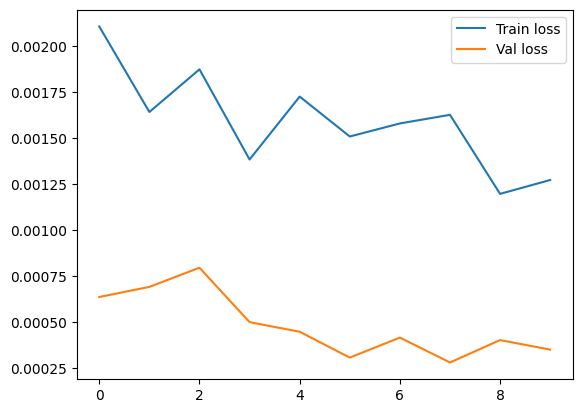

In [45]:
train_loss = [i.item() for i in train_loss]
val_loss = [i.item() for i in val_loss]

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.show()

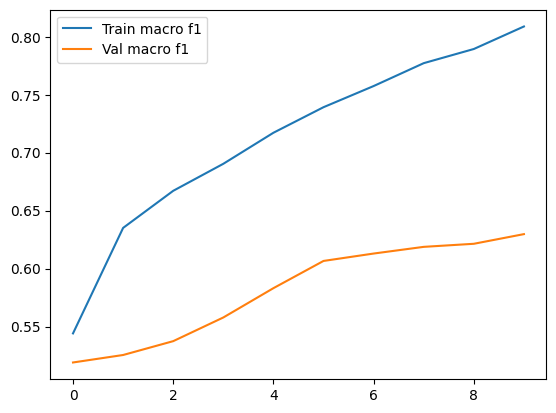

In [46]:
train_f1 = [i.item() for i in train_macro_f1]
val_f1 = [i.item() for i in val_macro_f1]

plt.plot(train_f1, label='Train macro f1')
plt.plot(val_f1, label='Val macro f1')
plt.legend()
plt.show()